# Notebook: Denoising MNIST using an autoencoder
This notebook is based on the Keras blog ["Building Autoencoders in Keras"](https://blog.keras.io/building-autoencoders-in-keras.html).

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Load the MNIST data train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Load the fashion MNIST data train and test sets
#(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


add some Gaussian noise to the images

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.7

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

take a look

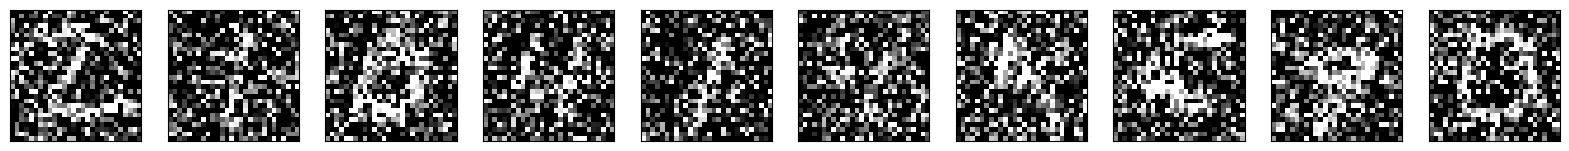

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

this is our denoising autoencoder

In [5]:
input_img = keras.Input(shape=(28, 28, 1))

n_filters = 32
 
x = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy')

Visualize the network

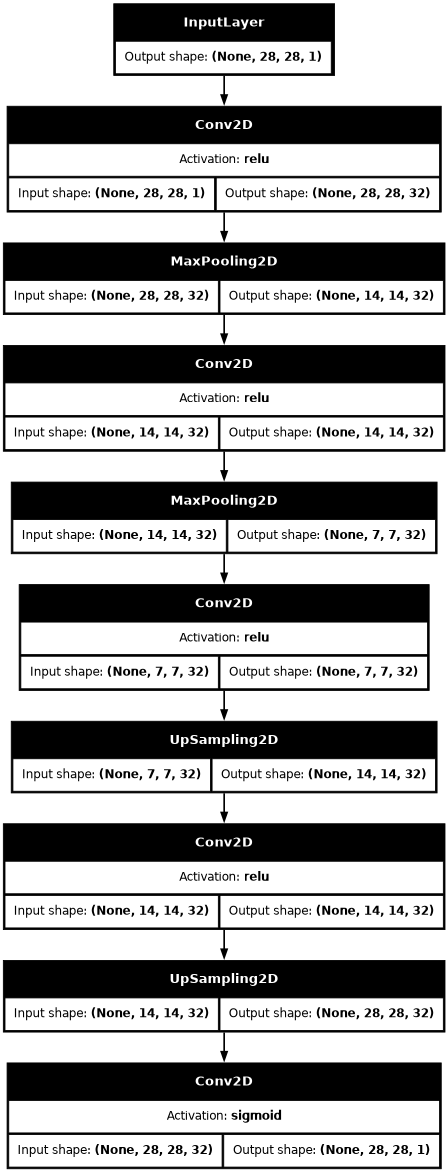

In [6]:
keras.utils.plot_model(autoencoder,
           show_shapes=True,
           show_layer_activations=True,
           dpi=60,)

# Fit the autoencoder

In [7]:
%%time

autoencoder.fit(x_train_noisy, # input data
                x_train,       # output data
                epochs=150,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=0,
               )

I0000 00:00:1763386737.366926      64 service.cc:145] XLA service 0x788bb0003f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763386737.366987      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763386739.748086      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


CPU times: user 5min 20s, sys: 22.8 s, total: 5min 43s
Wall time: 4min 32s


# Predict and visualize

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


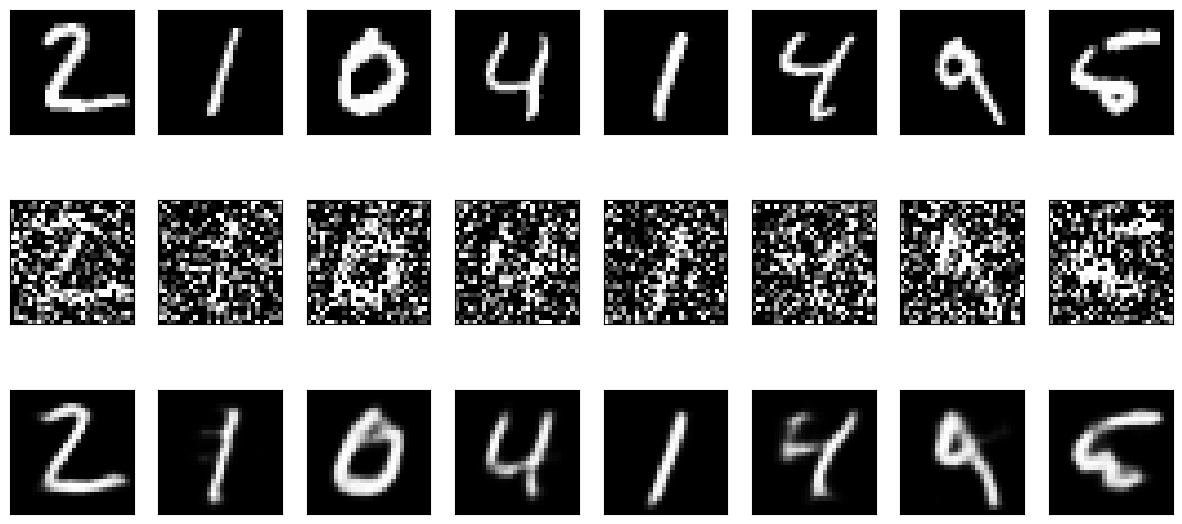

In [8]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 8
plt.figure(figsize=(15, 7))

for i in range(1, n + 1):
    # ground truth images
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # noisy images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # denoised images
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()